In [1]:
import os
os.chdir('../')
%pwd

'/home/dheeraj/Projects/Explainable-AI-Non-EEG'

# Load model for evaluation

In [2]:
from src.constants.constants import *
from src.utils.utils import *
import seaborn as sns
import numpy as np
import tensorflow as tf

2023-11-14 23:28:52.140324: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 23:28:52.162062: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 23:28:52.162080: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 23:28:52.162096: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 23:28:52.166396: I tensorflow/core/platform/cpu_feature_g

In [11]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix


def preprocess_test_data(test_data):
    """
    Preprocesses the given test data by subtracting the mean and dividing by the standard deviation.

    Parameters:
        test_data (ndarray): The test data to be preprocessed.

    Returns:
        ndarray: The preprocessed test data.
    """
    # Normalize the test data
    test_data = (test_data - test_data.mean()) / test_data.std()
 
    # Reshape the test data to include an additional dimension
    test_data = test_data.reshape(test_data.shape + (1,))
    
    return test_data

def evaluate_test_data(test_data, test_labels, model):
    """
    Evaluate the test data using the trained model.
    
    Args:
        test_data (numpy.ndarray): The test data.
        test_labels (numpy.ndarray): The labels for the test data.
        model (object): The trained model.
    """
    # Preprocess the test data
    test_data = preprocess_test_data(test_data)
    
    # Predict the labels for the test data
    pred = model.predict(test_data)
    
    # Convert the predicted probabilities to class labels
    y_pred = np.argmax(pred, axis=1)
    
    # Compute the confusion matrix
    cm = confusion_matrix(np.int16(test_labels), y_pred, normalize='true')
    
    # Compute the accuracy
    acc = accuracy_score(np.int16(test_labels), y_pred) * 100
    
    # Print the accuracy
    print('Accuracy:', acc)
    
    # Plot the normalized confusion matrix
    sns.heatmap(cm/np.sum(cm, axis=1), annot=True, fmt='.2%', cmap='Blues')

2/2 [==============================] - 0s 310ms/step
Accuracy: 69.04761904761905


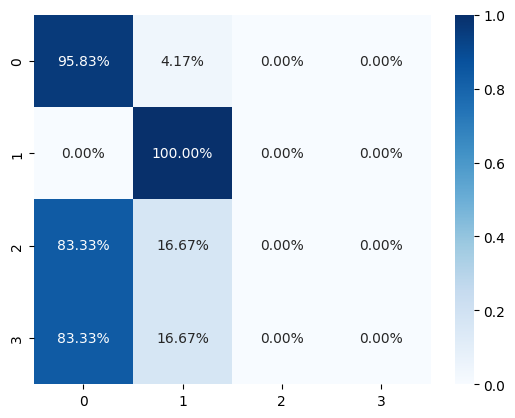

In [13]:
MODEL_PATH = os.path.join(SAVED_MODEL_DIR, 'model_LOSO_0_1Hz.h5')
model = tf.keras.models.load_model(MODEL_PATH)
test_df = load_dataframe_from_pickle(os.path.join(SAVED_DATASET_DIR, "test_data_LOSO_0.pkl"))
test_data, test_labels = dataframe_to_array(test_df)
evaluate_test_data(test_data, test_labels, model)

2023-11-14 23:30:20.289708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-14 23:30:20.349345: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-11-14 23:30:20.349367: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-11-14 23:30:20.349428: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


5/5 [==============================] - 1s 73ms/step
Accuracy: 50.71428571428571


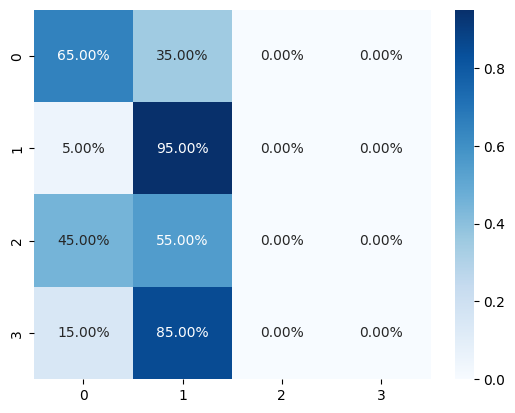

In [8]:
MODEL_PATH = os.path.join(SAVED_MODEL_DIR, 'model_LOSegO_0_1_1Hz.h5')
model = tf.keras.models.load_model(MODEL_PATH)
test_df = load_dataframe_from_pickle(os.path.join(SAVED_DATASET_DIR, "test_data_LOSegO_0_1_1Hz.pkl"))
test_data, test_labels = dataframe_to_array(test_df)
evaluate_test_data(test_data, test_labels, model)

In [18]:
test_df

,Data,Label,Label_ori,Subject


In [16]:
import matplotlib.pyplot as plt

modals = MODALS
x_test = np.array([np.array(xi, dtype='float32') for xi in test_df['Data'].values])
y_test = test_df['Label']    
y_test_ori = test_df['Label_ori']
x_test_std = x_test.std()
x_test_mean = x_test.mean()
x_test = (x_test - x_test_mean)/(x_test_std)
x_test = x_test.reshape(x_test.shape + (1,))

get_last_conv = keras.backend.function([model.layers[0].input], [model.layers[-3].output])
last_conv = get_last_conv([x_test])[0]
get_softmax = keras.backend.function([model.layers[0].input], [model.layers[-1].output])
softmax = get_softmax(([x_test]))[0]
softmax_weight = model.get_weights()[-2]
CAM = np.dot(last_conv, softmax_weight)

def grad_cam_modal_1(CAM=CAM, modal=0):
    
    a = 5  # number of rows
    b = 2  # number of columns
    d = 1  # initialize plot counter
    plt.figure(figsize=(12, 15))
        
    for k in range(0, 7):   
                
        CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True)) #min-max normalization
        c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
        
        plt.subplot(a, b, d)
        plt.title('Modality:' + modals[k] + '  likelihood of label:' + y_test_ori[modal] + ': ' + 
                  str(round(softmax[modal][int(y_test[modal])], 2)))
        plt.plot(x_test[modal, :, k].squeeze());  
        plt.scatter(np.arange(len(x_test[k])), x_test[modal, :, k].squeeze(), 
                    cmap='hot_r', c=c[modal, :, k, int(y_test[modal])].squeeze(), s=100);   #np.arange(len(x_val[k])
        plt.colorbar();
        d = d + 1
    
    plt.tight_layout()
    #plt.savefig('saved_model_new/All_modalities/LoSego/8Hz-60s/3'+str(modal)+'Sub2')
    plt.show()


In [ ]:
for i in range(0,7):
    grad_cam_modal_1(CAM, modal=i)

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import cv2
#%matplotlib inline

def grad_cam(image, model, model_layer, class_name='Relax_1', color=False):
    
    img_bgr = image
    
    if color==True:
        test_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        test_img = np.expand_dims(test_img, axis=0)
    else:
        test_img = img_bgr
        test_img = np.expand_dims(test_img, axis=0)
    
    last_conv_layer = model.get_layer(model_layer) #model.get_layer("conv2d_7") 
    heatmap_model = tf.keras.models.Model(inputs=model.input,
                                          outputs=[last_conv_layer.output, model.output])
    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(test_img)
        loss = predictions[:, np.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))#, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    
    img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2RGB)
    img_bgr = (((img_bgr - img_bgr.min())/(img_bgr.max()-img_bgr.min())) * 255).astype(np.uint8)
    
    squeezed_hm = np.squeeze(heatmap)
    normalized_hm = cv2.resize(squeezed_hm, (img_bgr.shape[1], img_bgr.shape[0]))
    
    normalized_hm = (255 * normalized_hm).astype(np.uint8)
    normalized_hm = cv2.applyColorMap(normalized_hm, cv2.COLORMAP_JET)
    
    rows, cols = 1, 1
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5))
    
    plt.setp(axs, yticks=[0,1,2,3,4,5,6], yticklabels=modals)    
    
    #ax1 = axs[0].imshow(cv2.cvtColor(img_bgr.transpose(1, 0, 2), cv2.COLOR_BGR2RGB), cmap='Greys_r', vmin=0, vmax=1)
    #axs[0].set_title('Original | '+ class_name)
    #axs[0].set_aspect('equal')
    #fig.colorbar(ax1, ax=axs[0]);
    
    ax2 = axs.imshow(cv2.cvtColor(normalized_hm.transpose(1, 0, 2), cv2.COLOR_BGR2RGB), cmap='jet', vmin=0, vmax=1)
    axs.set_title('Normalized Grad-CAM | '+str(class_name)+' | Sub1')
    fig.colorbar(ax2, ax=axs, shrink=0.38);
    

    #axs[1].set_aspect('equal')
    
    #ax3 = axs[2].imshow(cv2.cvtColor(superimposed_img.transpose(1, 0, 2), cv2.COLOR_BGR2RGB), cmap='jet')
    #axs[2].set_title('Applied Grad-CAM')
    #fig.colorbar(ax3, ax=axs[2]);
   #fig.savefig('saved_model_new/All_modalities/LoSego/8Hz-60s/3'+str(class_name)+'Sub1')

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 7, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 60, 7, 32)         2080      
                                                                 
 batch_normalization (Batch  (None, 60, 7, 32)         128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 60, 7, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 7, 32)         65568     
                                                                 
 batch_normalization_1 (Bat  (None, 60, 7, 32)         128       
 chNormalization)                                            

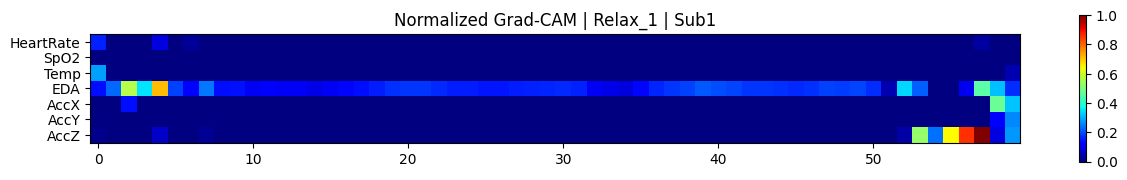

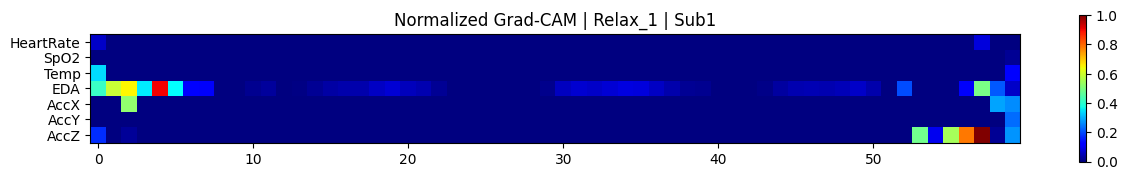

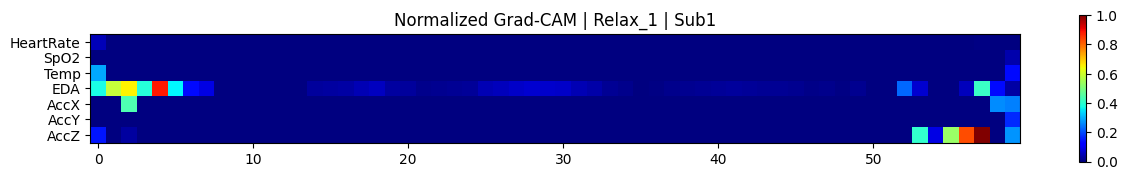

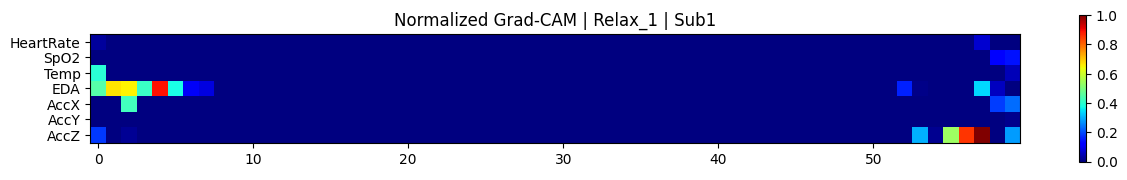

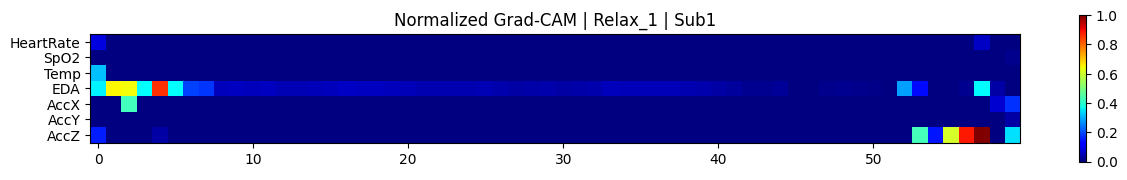

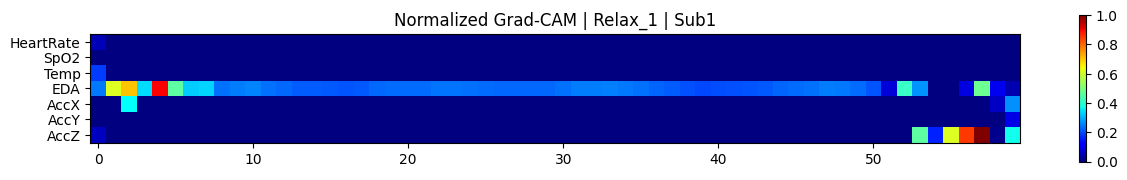

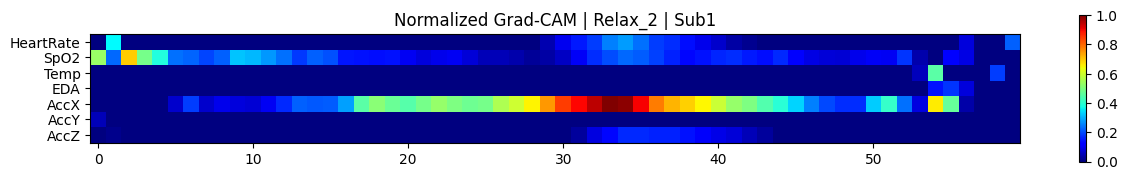

In [21]:
last_conv_layer = 'conv2d_2'
subject= 0
num_seg = 7

for i in range(subject*num_seg, num_seg + subject*num_seg):
    norm_hm = grad_cam(x_test[i].squeeze(), model=model, model_layer=last_conv_layer, 
             class_name=y_test_ori[i], color=False)

In [22]:
y_test_ori

0             Relax_1
1             Relax_1
2             Relax_1
3             Relax_1
4             Relax_1
5             Relax_1
6             Relax_2
7             Relax_2
8             Relax_2
9             Relax_2
10            Relax_2
11            Relax_2
12            Relax_3
13            Relax_3
14            Relax_3
15            Relax_3
16            Relax_3
17            Relax_3
18            Relax_4
19            Relax_4
20            Relax_4
21            Relax_4
22            Relax_4
23            Relax_4
24     PhysicalStress
25     PhysicalStress
26     PhysicalStress
27     PhysicalStress
28     PhysicalStress
29     PhysicalStress
30    CognitiveStress
31    CognitiveStress
32    CognitiveStress
33    CognitiveStress
34    CognitiveStress
35    CognitiveStress
36    EmotionalStress
37    EmotionalStress
38    EmotionalStress
39    EmotionalStress
40    EmotionalStress
41    EmotionalStress
Name: Label_ori, dtype: object